<a href="https://colab.research.google.com/github/seunghy1468/Sparta_Coding_Machine_Learning/blob/main/homework_4_weeks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# CNN으로 풍경사진 분류
# 전이학습 기법을 이용해 ResNet model을 가져와서 분류

import os
os.environ['KAGGLE_USERNAME'] = ''              # username
os.environ['KAGGLE_KEY'] = '' # key

!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip

 96% 334M/346M [00:02<00:00, 130MB/s]
100% 346M/346M [00:02<00:00, 124MB/s]


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


In [4]:
train_datagen = ImageDataGenerator(
  rescale=1./255,           # 일반화
  rotation_range=10,        # 랜덤하게 이미지를 회전 (단위: 도, 0-180) -10, 10
  zoom_range=0.1,           # 랜덤하게 이미지 확대 (%) -10%에서 +10%까지
  width_shift_range=0.1,    # 랜덤하게 이미지를 수평으로 이동 (%) 10%만큼 좌우로 움직임
  height_shift_range=0.1,   # 랜덤하게 이미지를 수직으로 이동 (%) 10%만큼 위아래로
  horizontal_flip=True      # 랜덤하게 이미지를 수평으로 뒤집기. 좌우로 반전 (상황에 따라 결정)
)

test_datagen = ImageDataGenerator(
  rescale=1./255            # 일반화
)

train_gen = train_datagen.flow_from_directory(
  'seg_train/seg_train',
  target_size=(224, 224),   # resize (height, width)
  batch_size=32,
  seed=2021,                # random seed; 어떻게 섞을 것인가
  class_mode='categorical', # label이 하나일땐 binary, 여러개면 categorical
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'seg_test/seg_test',
  target_size=(224, 224),   # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
from pprint import pprint
pprint(train_gen.class_indices)

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}


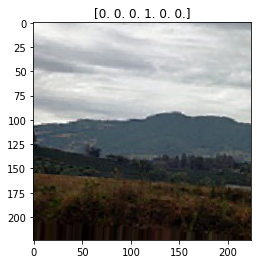

In [8]:
# 0번 배치의 아이템을 가져옴
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

# 라벨은 문자열로 출력, 이미지는 그냥 보여줌
# augmentation을 해서 다 똑같은 iamge가 나오진 않는다
plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

In [12]:
# ResNet
from tensorflow.keras.applications import ResNet50

# color image: 3
input = Input(shape=(224, 224, 3))

# base model == backbone model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

# x: base model에서 나온 출력
x = base_model.output

# 25%정도의 node를 random으로 제외
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)

output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 다항 분류를 하니까 categorical
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
# total params: 약 24,000,000
# model 저장 (model.h5란 이름으로)
from tensorflow.keras.callbacks import ModelCheckpoint
 
history = model.fit(
    train_gen,
    validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20,                # epochs 복수형으로 쓰기!
    callbacks=[               # verbose=1: va_acc가 증가할 때마다 저장 메시지
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
439/439 [==============================] - 251s 486ms/step - loss: 1.3189 - acc: 0.7108 - val_loss: 1.8801 - val_acc: 0.2120

Epoch 00001: val_acc improved from -inf to 0.21200, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
439/439 [==============================] - 211s 479ms/step - loss: 0.4750 - acc: 0.8369 - val_loss: 0.8054 - val_acc: 0.6993

Epoch 00002: val_acc improved from 0.21200 to 0.69933, saving model to model.h5
Epoch 3/20
439/439 [==============================] - 210s 479ms/step - loss: 0.4127 - acc: 0.8584 - val_loss: 0.7343 - val_acc: 0.7917

Epoch 00003: val_acc improved from 0.69933 to 0.79167, saving model to model.h5
Epoch 4/20
439/439 [==============================] - 210s 478ms/step - loss: 0.3591 - acc: 0.8804 - val_loss: 0.4566 - val_acc: 0.8393

Epoch 00004: val_acc improved from 0.79167 to 0.83933, saving model to model.h5
Epoch 5/20
439/439 [==============================] - 210s 477ms/step - loss: 0.3384 - acc: 0.8846 - val_loss: 0.6072 - val_acc: 0.7947

Epoch 00005: val_acc did not improve from 0.83933
Epoch 6/20
439/439 [==============================] - 209s 476ms/step - loss: 0.3319 - acc: 0.8843 - val_loss: 0.4796 - val_acc: 0.8233

Epoch 00006: val_acc did 

Model loaded!


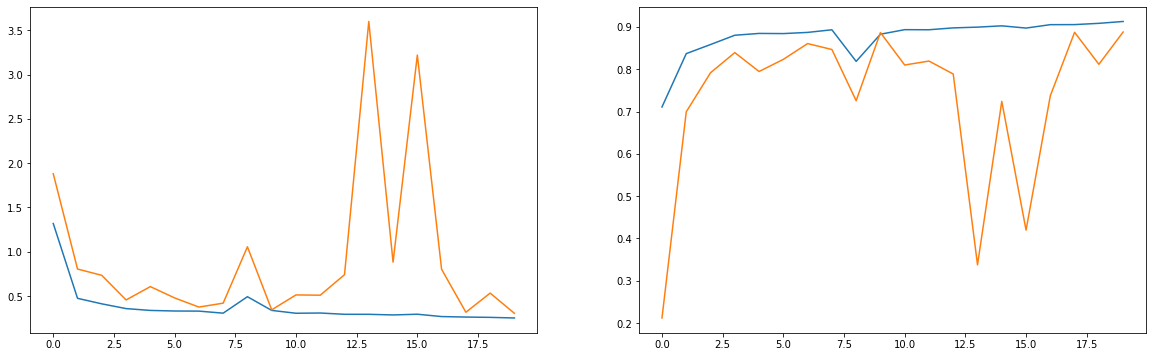

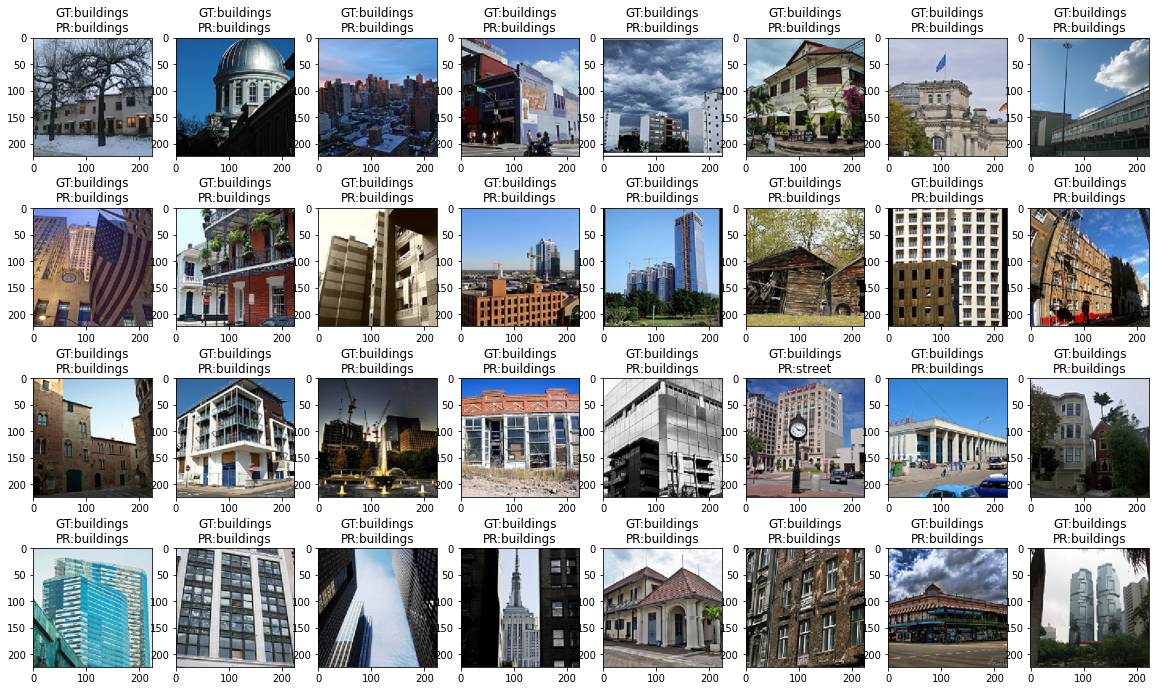

In [14]:
# 학습결과 그래프
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

# 학습된 model load
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

# test
test_imgs, test_labels = test_gen.__getitem__(10)

# predict 함수를 이용
# 예측한 label 출력
y_pred = model.predict(test_imgs)

# 예측한 label을 class로 변환
classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

# argmax: one hot encoding이 된 것을 다시 class index로 바꿔준다
for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)
  # GT: 정답 값
  # PR: 예측한 값